# Introduction
This is a jupyter notebook to design and train a CNN, to predict whether a map is good enough for prediction and output.

The basic idea is to apply AlexNet.

And we would like to train three AlexNet
1. Standard 8 layer AlexNet, with 5 convolutional layer and 3 fully connected layer (with dropout)
2. Based on 1, but with sparser neural elements
3. Based on 1, but with deeper network architecture, we add to 6 convolutional layer and 4 fully connected layer

As for the loss function, apply the weighted cross entropy function.

# Development Environment
The script is developed under python3 and tensorflow, and during a normal CPU, the training process take a time about ///TBD///

In [49]:
import sys
import os
import datetime
from random import shuffle


import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
from sklearn.metrics import roc_auc_score    

# Training Configuration

In [6]:
IMG_SIZE = 80

epochs = 10
batch = 8

validating_size = 40
nodes_fc1 = 4096
nodes_fc2 = 4096
output_classes = 2

IMG_SIZE_ALEXNET = 227

TRAIN_DIR = os.getcwd()
print(TRAIN_DIR) 

/Users/cesare/Downloads/TensorFlow-Binary-Image-Classification-using-CNN-s-master


# Analysis
For the input image data, we have 1 hypothesis:

> **Whether the input image data pixel value will have an influence on the training effect.**

Here are two encoding methods in matlab -- The image are single channel

Each pixel could be
1. Free
2. Obstacle
3. Unknown

So we should assign 0/128/255 to one pixel. We would like to preprocessed data to see if different assignment of pixel value will influence the outcome
1. Free - 0 / Obstacle - 128 / Unknown - 255
2. Free - 0 / Unknown - 128 / Unknown - 255

Aother problem is that whether we should assign a pixel to **frontier** explicitly? Or we should let the model to learn it by itself.

After above process, we should do some shift and rotation on our input, to make our model more robust to noise and decrease the risk of becoming overfitting.

What's more, before we start, we have to define the confusion matrix:

                    real_good   real_bad
        ----------------------------------
        pred_good   c1=0        c2=10
        ----------------------------------
        pred_bad    c3=1        c4=0

        We need to say, whether the cose of c2 and c3 are the same?
        >> That is: The cost of falsely predict one good map to a bad map is just waster 
        >> more time on exploring, However, falsely predict one bad map to a good map
        >> could lead to a wrong map! Now we assign a 10 times greater cost


# Data Overview

In [22]:
original_train_data = np.load(os.path.join(os.getcwd(), 'datasets' ,'train_data_bi.npy'))
original_test_data = np.load(os.path.join(os.getcwd(), 'datasets' ,'test_data_bi.npy'))

print("the shape of train_data is: \t",(original_train_data.shape))
print("the shape of test_data is: \t",(original_test_data.shape))

the shape of train_data is: 	 (5000, 2)
the shape of test_data is: 	 (1243, 2)


In [23]:
# we would like to check the ratio of two binary classes in the training set
pos = 0
neg = 0
for i in original_train_data:
    one_hot_label = i[1]
    if one_hot_label[0] == 0:
        pos+=1
    else:
        neg+=1

print("The number of positive labels is %i" %pos)
print("The number of ngeative labels is %i" %neg)

The number of positive labels is 2483
The number of ngeative labels is 2517


# Original Train/Test Data Pre-processing

In [55]:
# Seperate data into Training Set/Validation Set/Test Set

# Resize to AlexNet input size, which is 
for i in range(len(original_train_data)):
    original_train_data[i][0] = cv2.resize(original_train_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

for i in range(len(test_data)):
    original_test_data[i][0] = cv2.resize(original_test_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

# Split the train data in train set and validation set
validation_data = original_train_data[4000:]
train_data = original_train_data[:4000]

# cv means the validation part, but here why we need this reshape? I think it is useless

# X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
X = np.array([i[0] for i in train_data])
Y = np.array([i[1] for i in train_data])

# v_x = np.array([i[0] for i in validation_data]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
v_x = np.array([i[0] for i in validation_data])
v_y = np.array([i[1] for i in validation_data])

# test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
test_x = np.array([i[0] for i in original_test_data])
test_y = np.array([i[1] for i in original_test_data])

print(X.shape)
print(Y.shape)

print(v_x.shape)
print(v_y.shape)

print(test_x.shape)
print(test_y.shape)

(4000, 227, 227, 3)
(4000, 2)
(1000, 227, 227, 3)
(1000, 2)
(1243, 227, 227, 3)
(1243, 2)


In [38]:
steps = len(train_data)
remaining = steps % batch


# CNN Architecture - Convolutional

In [27]:
# Reset Calculate Graph
tf.reset_default_graph()

# Define Placeholder for a 3 Channel IMAGE
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3])
# x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,1])  ///TBD///
y = tf.placeholder(tf.float32,shape=[None,output_classes])

#------------CNN Layer1------------
# 1  channel input ///TBD///
# 96 channel output 55*55 each
w1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
# w1 = tf.Variable(tf.truncated_normal([11,11,1,96], stddev=0.01))   ///TBD///
b1 = tf.Variable(tf.constant(0.0, shape=[[11,11,3,96][3]]))

output1 = tf.nn.conv2d(x,w1,strides = [1,4,4,1], padding = 'VALID')
output1 = output1+b1
output1 = tf.nn.relu(output1)

#------------Pooling Layer1------------
# 96 channel input 55*55 each
# 96 channel output 27*27 each
output1 = tf.nn.max_pool(output1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

#------------CNN Layer2------------
# 96 channel input 27*27 each
# 256 channel output 27*27 each
w2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
b2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))

output2 = tf.nn.conv2d(output1, w2,strides=[1, 1, 1, 1], padding='SAME')
output2 = output2 + b2
output2 = tf.nn.relu(output2)

#------------Pooling Layer2------------
# 256 channel input 27*27 each
# 256 channel output 13*13 each
output2 = tf.nn.max_pool(output2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

#------------CNN Layer3------------
# 256 channel input 13*13 each
# 384 channel output 13*13 each
w3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
b3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))

output3 = tf.nn.conv2d(output2, w3,strides=[1, 1, 1, 1], padding='SAME')
output3 = output3 + b3
output3 = tf.nn.relu(output3)

#------------CNN Layer4------------
# 384 channel input 13*13 each
# 384 channel output 13*13 each
w4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
b4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))

output4 = tf.nn.conv2d(output3, w4,strides=[1, 1, 1, 1], padding='SAME')
output4 = output4 + b4
output4 = tf.nn.relu(output4)

#------------CNN Layer5------------
# 384 channel input 13*13 each
# 256 channel output 13*13 each
w5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
b5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))

output5 = tf.nn.conv2d(output4, w5,strides=[1, 1, 1, 1], padding='SAME')
output5 = output5 + b5
output5 = tf.nn.relu(output5)

#------------Pooling Layer3------------
# 256 channel output 13*13 each
# 256 channel output 6*6 each
output5 = tf.nn.max_pool(output5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

# CNN Architecture - Fully Connected

In [45]:
#------------Flatten------------
# 256 channel input 6*6 each
# output a vector or 6*6*256
flattened = tf.reshape(output5,[-1,6*6*256])

#------------Fully connected Layer1------------
# input_size = int(flattened.get_shape()[1])=6*6*256
# output neural nodes: nodes1_fc1
input_size = int(flattened.shape[1])
w1_fc = tf.Variable(tf.truncated_normal([input_size, nodes_fc1], stddev=0.01))
b1_fc = tf.Variable(tf.constant(1.0, shape=[nodes_fc1]))

output_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
output_fc1 = tf.nn.relu(output_fc1)

#------------Dropout Layer1------------
hold_prob1 = tf.placeholder(tf.float32)
# output_fc1 = tf.nn.dropout(output_fc1,rate=1-hold_prob1)
output_fc1 = tf.nn.dropout(output_fc1,keep_prob=hold_prob1)
# Here we should also use rate  = 1-keep_prob = 1-hold_prob


#------------Fully connected Layer2------------
# input neurons: nodes1_fc1
# output neurons: nodes1_fc2
w2_fc = tf.Variable(tf.truncated_normal([nodes_fc1, nodes_fc2], stddev=0.01))
b2_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc2]))

output_fc2 = tf.matmul(output_fc1, w2_fc) + b2_fc
output_fc2 = tf.nn.relu(output_fc2)

#------------Dropout Layer2------------
hold_prob2 = tf.placeholder(tf.float32)
# output_fc2 = tf.nn.dropout(output_fc2,rate=1-hold_prob2)
output_fc2 = tf.nn.dropout(output_fc2,keep_prob=hold_prob2)


#------------Fully Connected Layer 3------------
w3_fc = tf.Variable(tf.truncated_normal([nodes_fc2,output_classes], stddev=0.01))
b3_fc = tf.Variable(tf.constant(1.0, shape=[output_classes]))

prediction = tf.matmul(output_fc2, w3_fc) + b3_fc

# REMEMBER: In the output layer, we don't apply activate function, and we get a 2 dimension vector of y

In [46]:
#Defining loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=prediction))
#Define Loss function with specific confusion matrix ///TBD///

#Define objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)

#Define Accuracy
matches = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

#Global Initialization
init = tf.global_variables_initializer()

In [47]:
#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []
saver = tf.train.Saver()

In [56]:
# GPU Training

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'

currentDT = datetime.datetime.now()
print("------------Strat to Train------------")
print(str(currentDT))


with tf.Session(config=config) as sess:
    sess.run(init)
    
#     this is the training part
    
#     Here we only set the epochs to 5
    epochs = 5
    for i in range(epochs):
        for j in range(0,steps-remaining,batch):
            #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],
			feed_dict={x:X[j:j+batch] , y:Y[j:j+batch],hold_prob1:0.5,hold_prob2:0.5})
        
        
		#Writing for loop to calculate test statistics. GTX 1050 isn't able to calculate all test data.
        cv_auc_list = []
        cv_acc_list = []
        cv_loss_list = []
        # Validation after one epoch
        for v in range(0,len(v_x)-int(len(v_x) % validating_size),validating_size):
            acc_on_cv,loss_on_cv,preds = sess.run([acc,cross_entropy,tf.nn.softmax(prediction)],
			feed_dict={x:v_x[v:v+validating_size] ,y:v_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
			
            auc_on_cv = roc_auc_score(v_y[v:v+validating_size],preds)
            cv_acc_list.append(acc_on_cv)
            cv_auc_list.append(auc_on_cv)
            cv_loss_list.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc_list),5)
        auc_cv_ = round(np.mean(cv_auc_list),5)
        loss_cv_ = round(np.mean(cv_loss_list),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("------------Epoch %i Finished------------" %i)
        currentDT = datetime.datetime.now()
        print(str(currentDT))
        print("Epoch:",i,"Accuracy:",acc_cv_,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
    
    print("------------Training Stage Finished------------")
    
    print("            ")
    
    print("------------Test Stage Started------------")
    test_auc_list = []
    test_acc_list = []
    test_loss_list = []
    for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
        acc_on_test,loss_on_test,preds = sess.run([acc,cross_entropy,tf.nn.softmax(prediction)],
		feed_dict={x:test_x[v:v+validating_size] ,y:test_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
        
        auc_on_test = roc_auc_score(test_y[v:v+validating_size],preds)
        test_acc_list.append(acc_on_test)
        test_auc_list.append(auc_on_test)
        test_loss_list.append(loss_on_test)
    saver.save(sess, os.path.join(os.getcwd(),"CNN_MC.ckpt"))
    test_acc_ = round(np.mean(test_acc_list),5)
    test_auc_ = round(np.mean(test_auc_list),5)
    test_loss_ = round(np.mean(test_loss_list),5)
    print("Test Results are below:")
    print("Accuracy:",test_acc_,"Loss:",test_loss_,"AUC:",test_auc_)

------------Strat to Train------------
2019-05-26 18:01:58.731745
------------Epoch 0 Finished------------
2019-05-26 18:09:39.606132
Epoch: 0 Accuracy: 0.88 Loss: 0.27759 AUC: 0.94874
------------Epoch 1 Finished------------
2019-05-26 18:40:40.721191
Epoch: 1 Accuracy: 0.892 Loss: 0.2644 AUC: 0.95997
------------Epoch 2 Finished------------
2019-05-26 18:48:07.114755
Epoch: 2 Accuracy: 0.906 Loss: 0.24103 AUC: 0.9697
------------Epoch 3 Finished------------
2019-05-26 18:55:36.282777
Epoch: 3 Accuracy: 0.914 Loss: 0.22574 AUC: 0.97318
------------Epoch 4 Finished------------
2019-05-26 19:03:06.262751
Epoch: 4 Accuracy: 0.897 Loss: 0.29401 AUC: 0.97443
------------Training Stage Finished------------
            
------------Test Stage Started------------
Test Results are below:
Accuracy: 0.88226 Loss: 0.32138 AUC: 0.97511


In [58]:
print(acc_list)
print(loss_list)
print(auc_list)

[0.883, 0.882, 0.896, 0.888, 0.889, 0.882, 0.88, 0.892, 0.906, 0.914, 0.897]
[0.28916, 0.28066, 0.24371, 0.26594, 0.26489, 0.31179, 0.27759, 0.2644, 0.24103, 0.22574, 0.29401]
[0.95601, 0.95094, 0.9632, 0.96805, 0.97324, 0.97368, 0.94874, 0.95997, 0.9697, 0.97318, 0.97443]


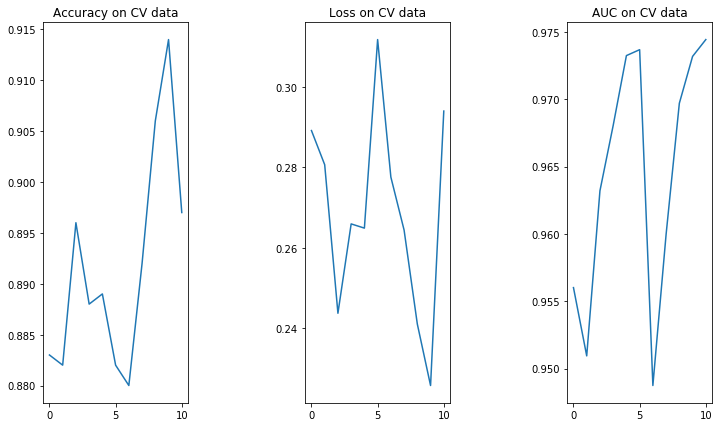

In [57]:
f,ax=plt.subplots(1,3,figsize=(12,3))
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data',ax=ax[0])
pd.Series(loss_list).plot(kind='line',figsize=(12,7),title='Loss on CV data',ax=ax[1])
pd.Series(auc_list).plot(kind='line',figsize=(12,7),title='AUC on CV data',ax=ax[2])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('Accuracy on CV data')
ax[1].set_title('Loss on CV data')
ax[2].set_title('AUC on CV data')
plt.show()

In [67]:
#Restoring a pretrained

# checkpoint = tf.train.latest_checkpoint(FLAGS.checkpoint)
# saver.restore(sess, checkpoint)

with tf.Session() as session:
    saver.restore(session, "CNN_MC.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([tf.nn.softmax(prediction)], feed_dict={x:test_x[0:64] , hold_prob1:1,hold_prob2:1})

print(np.array(k).shape)

INFO:tensorflow:Restoring parameters from CNN_MC.ckpt
Model restored.
Initialized
(1, 64, 2)


In [68]:
#Reshaping k
k = np.array(k).reshape(64,output_classes)

print(k[0])

pred_labels = []

for i in range(64):
    r = np.round(k[i],3).argmax()
    if r ==0 : pred_labels.append("glass")
    elif r ==1: pred_labels.append("table")

[4.2491173e-04 9.9957508e-01]


In [69]:
#Multiple images parameters
w=80
h=80
columns = 8
rows = 8

(64, 227, 227, 3)


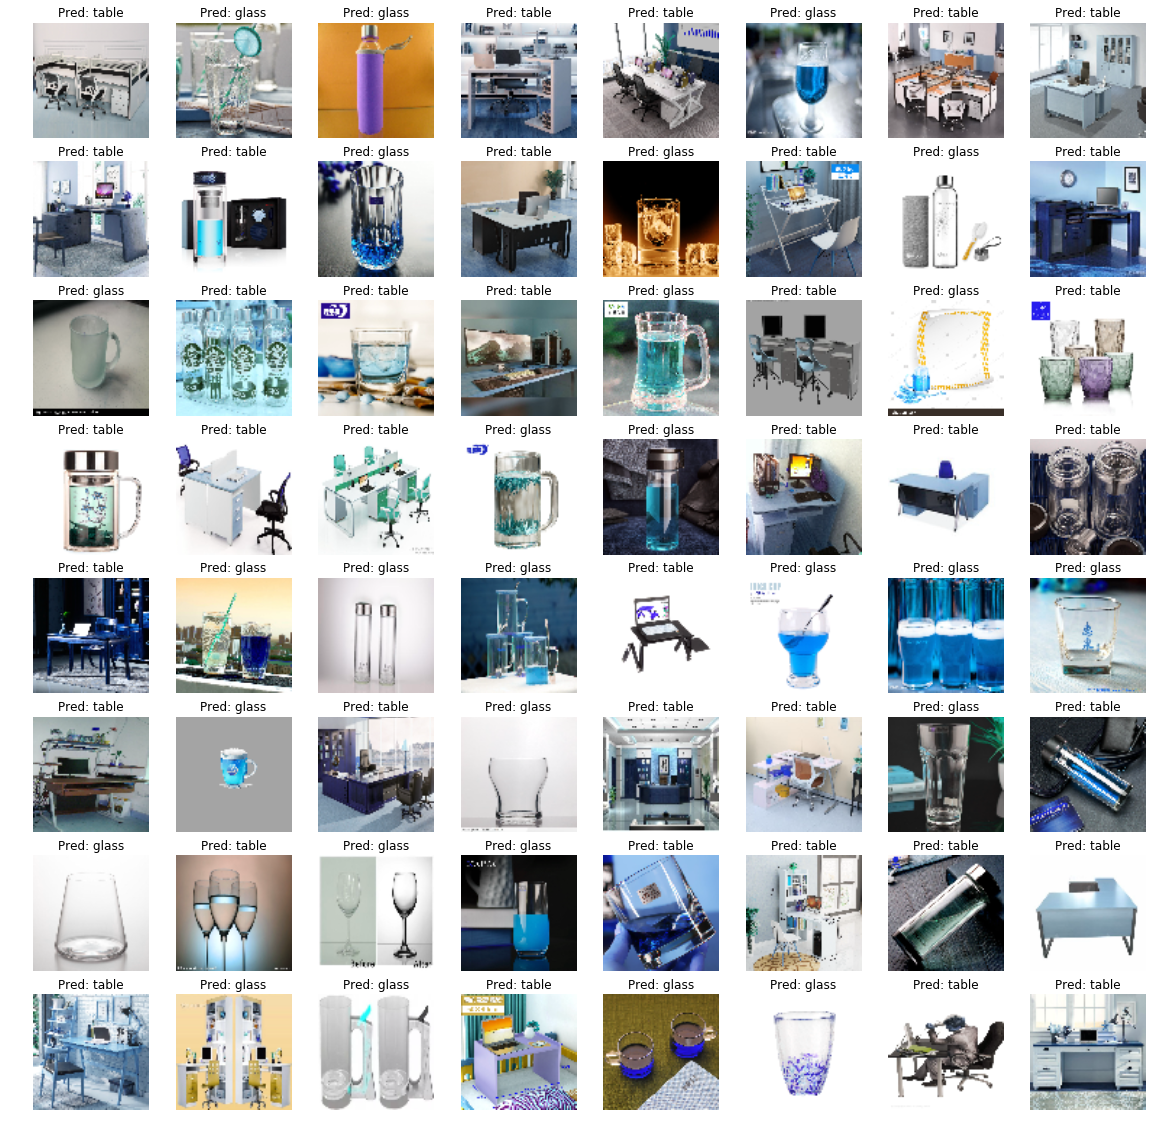

In [70]:
#First 64 images
images = test_x[:64]

print(images.shape)

fig = plt.figure(figsize=(20, 20))
for m in range(1, columns*rows +1):
    img = images[m-1].reshape([IMG_SIZE_ALEXNET, IMG_SIZE_ALEXNET, 3])
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Pred: " + pred_labels[m-1])
    plt.axis('off')
plt.show()